## Import 

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box, from_file
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import minimize
from sklearn.metrics import jaccard_score
import cv2
import seaborn as sns
import geopandas as gpd
import folium
import contextily as cx

from sklearn.model_selection import StratifiedKFold, KFold
import torch
print(torch.__version__)
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
import segmentation_models_pytorch as smp
# from torchmetrics import FBetaScore
import ttach as tta

import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger, CSVLogger
from pytorch_lightning import LightningDataModule, LightningModule

# import wandb
# wandb.login(key=os.environ["WANDB_API_KEY"])

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

1.10.2
1.6.5


In [2]:
cfg = {"eps":1e-5}
cfg = Box(cfg)

In [3]:
DATA_CSV = '../data/001_Fire_Only/001_seed417.csv'

In [4]:
data_df = pd.read_csv(DATA_CSV)
print(data_df.shape)

(534, 6)


In [5]:
data_df.head(12)

,name,feature,mask,defects,fold,cv
0,012b8863-976c-44e1-a491-9adf19c1cbba_0,../data/001_Fire_Only/img/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy,../data/001_Fire_Only/ann/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy,False,1,3
1,0328d12a-4ad8-4504-8ac5-70089db10b4e_0,../data/001_Fire_Only/img/0328d12a-4ad8-4504-8ac5-70089db10b4e_0.npy,../data/001_Fire_Only/ann/0328d12a-4ad8-4504-8ac5-70089db10b4e_0.npy,False,4,3
2,0328d12a-4ad8-4504-8ac5-70089db10b4e_1,../data/001_Fire_Only/img/0328d12a-4ad8-4504-8ac5-70089db10b4e_1.npy,../data/001_Fire_Only/ann/0328d12a-4ad8-4504-8ac5-70089db10b4e_1.npy,False,4,0
3,03790d1a-5b9c-48ed-820d-83abbe656035_0,../data/001_Fire_Only/img/03790d1a-5b9c-48ed-820d-83abbe656035_0.npy,../data/001_Fire_Only/ann/03790d1a-5b9c-48ed-820d-83abbe656035_0.npy,False,3,3
4,03790d1a-5b9c-48ed-820d-83abbe656035_1,../data/001_Fire_Only/img/03790d1a-5b9c-48ed-820d-83abbe656035_1.npy,../data/001_Fire_Only/ann/03790d1a-5b9c-48ed-820d-83abbe656035_1.npy,False,3,3
5,039885ad-e4f2-461e-9784-60508d0a7ab5_0,../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_0.npy,../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_0.npy,False,1,1
6,039885ad-e4f2-461e-9784-60508d0a7ab5_1,../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_1.npy,../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_1.npy,False,1,3
7,039885ad-e4f2-461e-9784-60508d0a7ab5_2,../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_2.npy,../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_2.npy,False,1,0
8,039885ad-e4f2-461e-9784-60508d0a7ab5_3,../data/001_Fire_Only/img/039885ad-e4f2-461e-9784-60508d0a7ab5_3.npy,../data/001_Fire_Only/ann/039885ad-e4f2-461e-9784-60508d0a7ab5_3.npy,False,1,1
9,051de91d-9d50-423a-a130-4e51bd0d33f7_0,../data/001_Fire_Only/img/051de91d-9d50-423a-a130-4e51bd0d33f7_0.npy,../data/001_Fire_Only/ann/051de91d-9d50-423a-a130-4e51bd0d33f7_0.npy,False,4,0


In [7]:
OUTPUT_ROOT = '../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold0/inference_cloud/visualize/'

In [8]:
cloud_predict_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT,'*_predict.png')))

# Check

In [9]:
idx = 0
name = data_df['name'].iloc[idx]
print(idx, name)

0 012b8863-976c-44e1-a491-9adf19c1cbba_0


In [10]:
mask = np.load(data_df['mask'].iloc[idx]).squeeze()

In [11]:
cloud_predict_paths = glob.glob(os.path.join(OUTPUT_ROOT,name+'*_pos_predict.png'))
cloud_predict_paths

['../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold0/inference_cloud/visualize/012b8863-976c-44e1-a491-9adf19c1cbba_0_pos_predict.png']

In [12]:
thr = 255*0.5

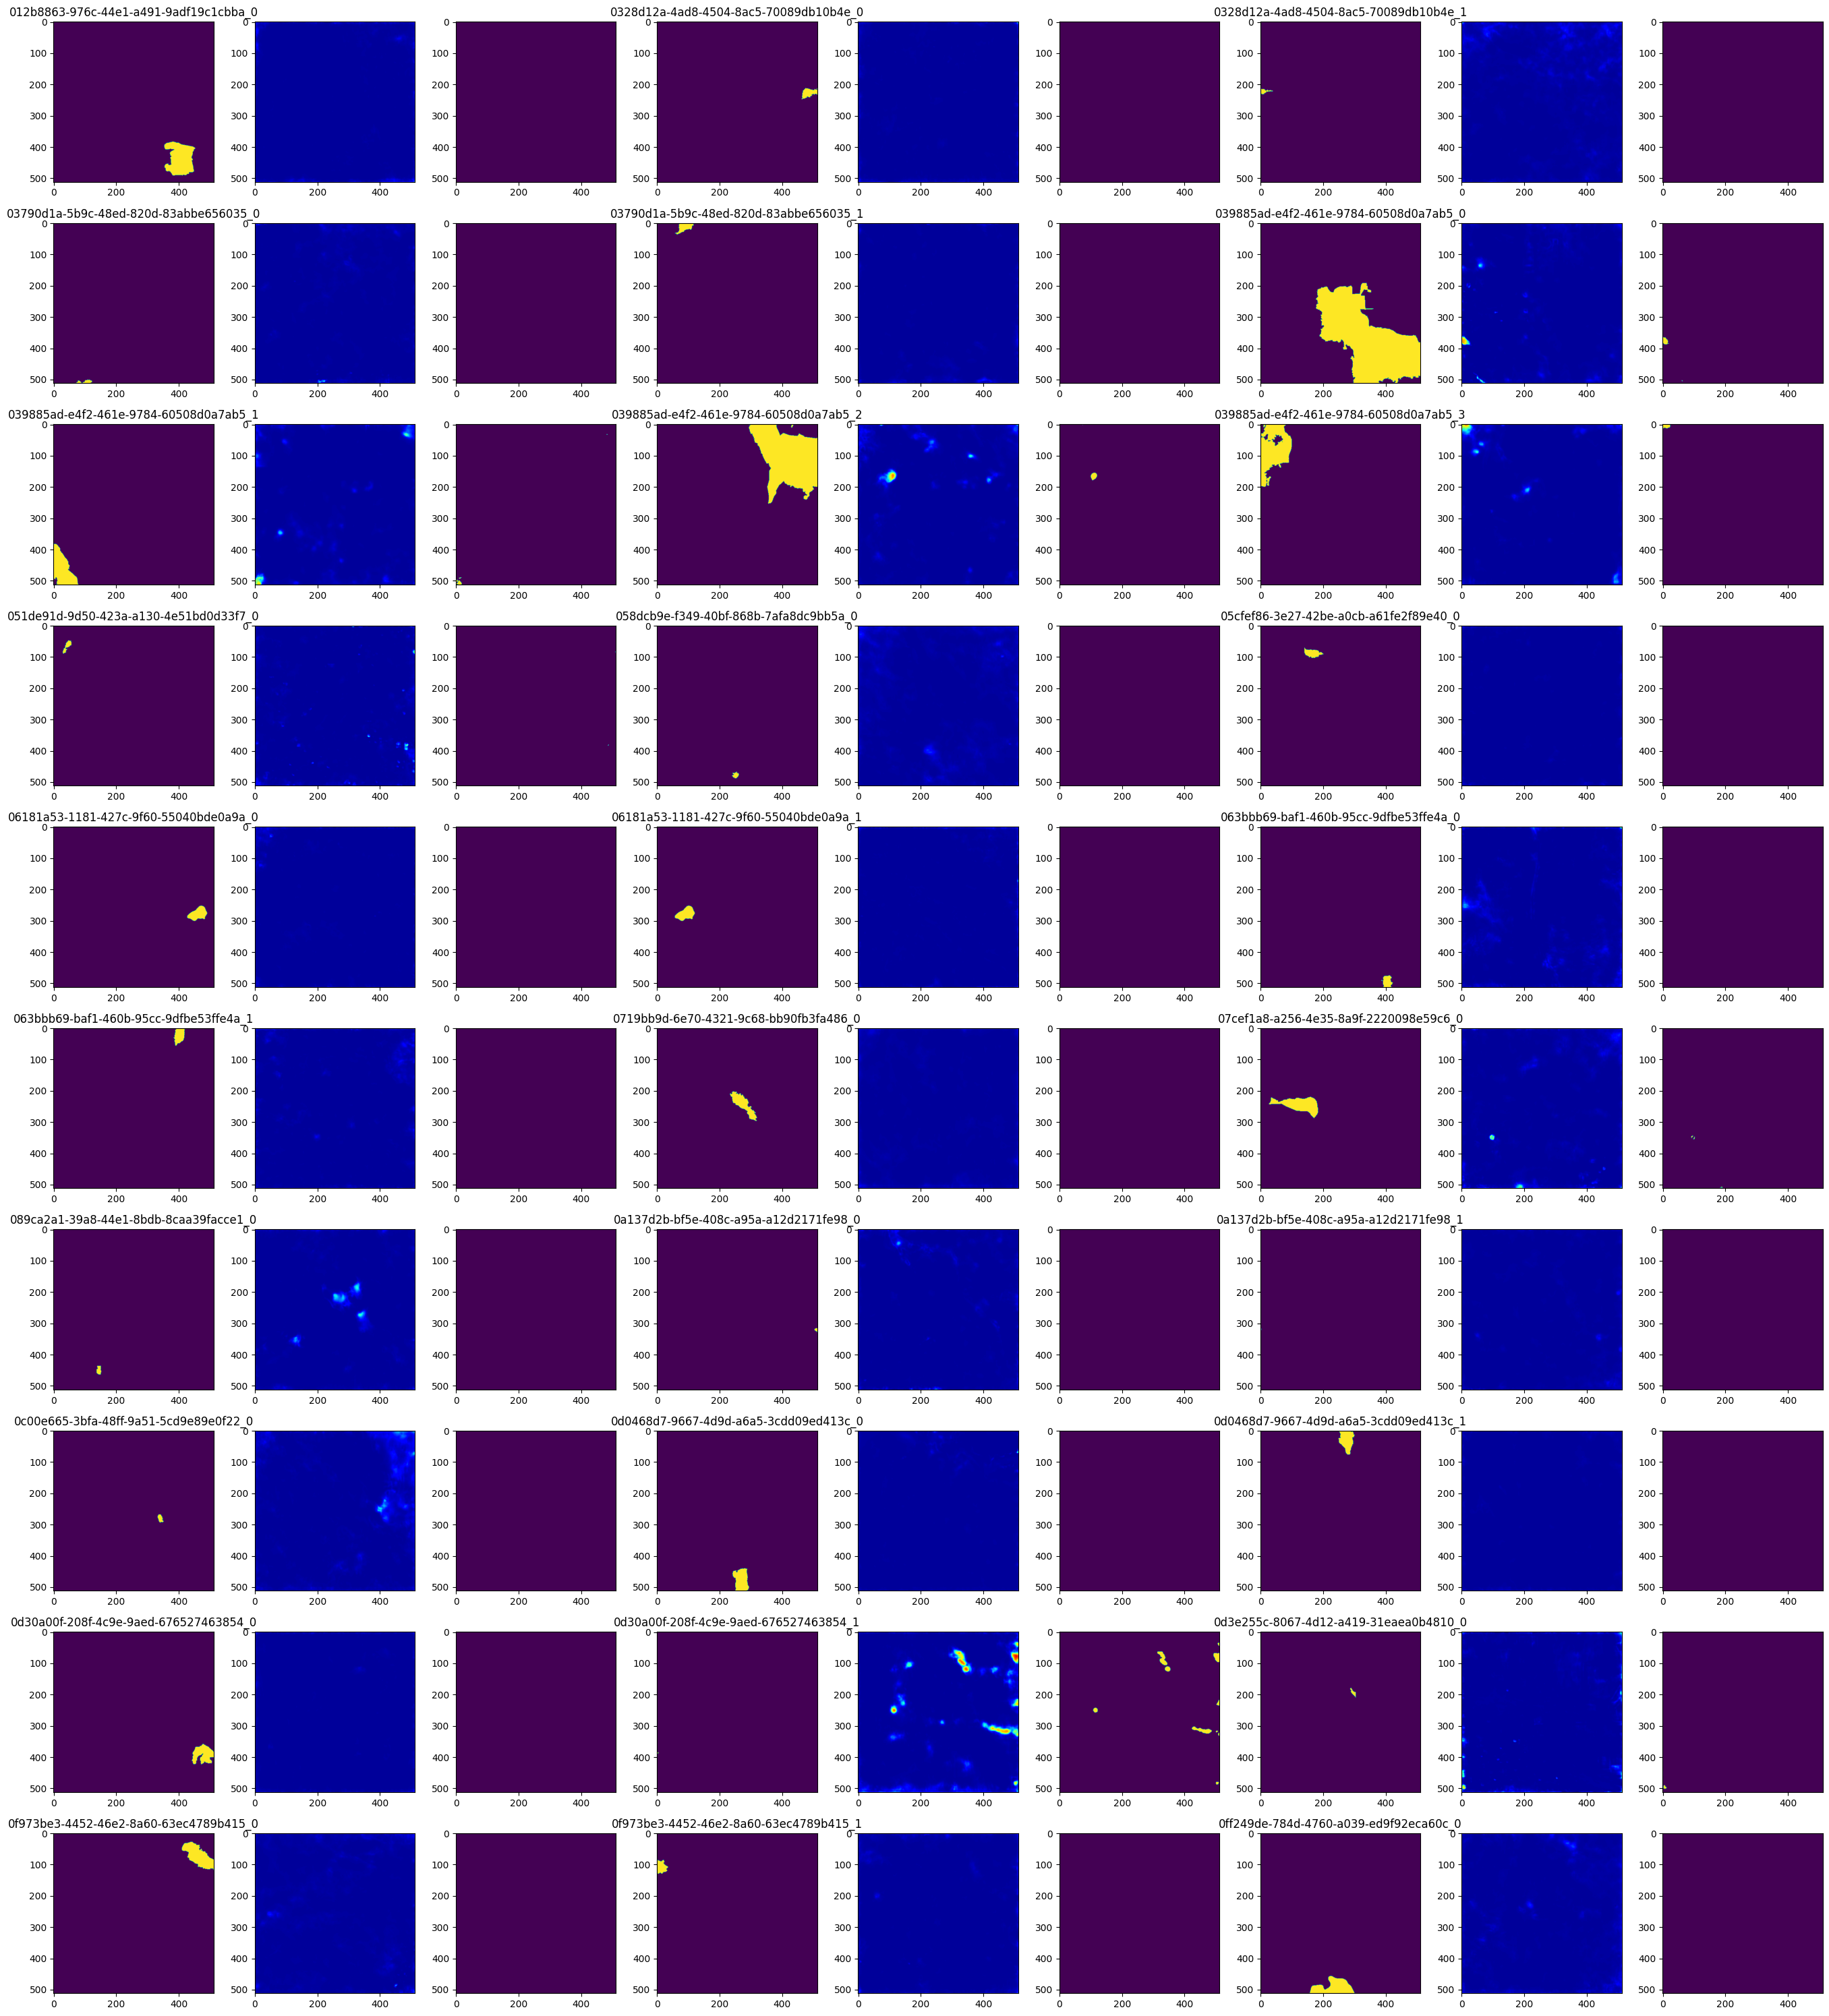

In [13]:
PANEL_SIZE = 3
n_rows = 10
n_cols = 9

pair_df = data_df

fig, axes = plt.subplots(n_rows, n_cols,figsize=(PANEL_SIZE*n_cols,PANEL_SIZE*n_rows), tight_layout=True)
axes = axes.ravel()
j=0
for k in range(n_rows*n_cols//3):
    name = pair_df['name'].iloc[k]
    mask_path = pair_df['mask'].iloc[k]
    try:
        mask = np.load(mask_path).squeeze()
        axes[j].imshow(mask)
        axes[j].set_title(name)
        j+=1
        cloud_predict_path = glob.glob(os.path.join(OUTPUT_ROOT, name+'*_pos_predict.png'))[0]
        cloud_proba = cv2.imread(cloud_predict_path, 0)
        cloud_pred = cloud_proba>thr

        axes[j].imshow(cloud_proba, cmap='jet', vmin=0, vmax=255)
        j+=1
        axes[j].imshow(cloud_pred, )
        j+=1

    except Exception as e:
        # pass
        print(k, name, e)
plt.show()

In [14]:
result_scores = {}
for k in range(len(pair_df)):
    name = pair_df['name'].iloc[k]
    mask_path = pair_df['mask'].iloc[k]
    mask = np.load(mask_path).squeeze()
    try:
        cloud_predict_path = glob.glob(os.path.join(OUTPUT_ROOT,name+'*_pos_predict.png'))[0]
        cloud_proba = cv2.imread(cloud_predict_path, 0)
        cloud_pred = cloud_proba>thr

        # metrics
        tp = (cloud_pred * mask).sum()
        tn = ((1. - cloud_pred) * (1. - mask)).sum()
        fp = (cloud_pred * (1. - mask)).sum()
        fn = ((1. - cloud_pred) * mask).sum()

        precision = tp / (tp + fp + cfg.eps)
        recall = tp / (tp + fn + cfg.eps)
        f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
        iou = tp / (tp + fp + fn + cfg.eps)

        result_scores[name] = {
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'iou': iou,
        }
    except Exception as e:
        print(k, name, e)

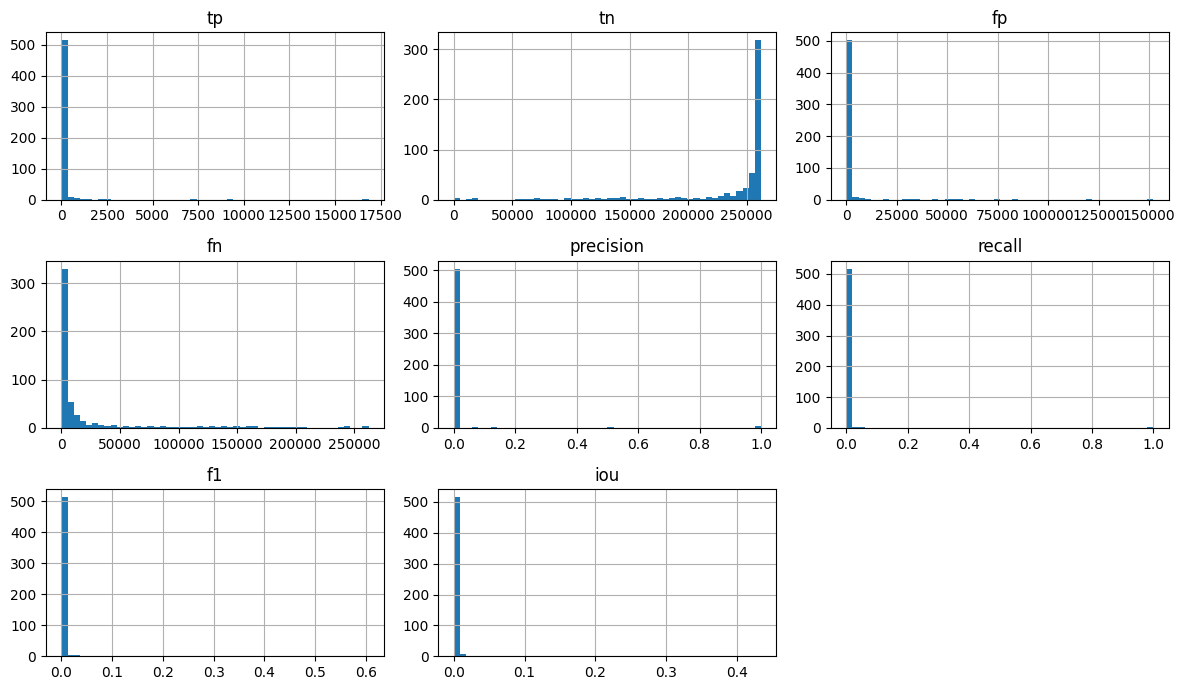

In [15]:
result_scores_df = pd.DataFrame(result_scores).T
fig, ax = plt.subplots(figsize=(12,7), tight_layout=True)
result_scores_df.hist(bins=50, ax=ax)
plt.show()

In [16]:
print(result_scores_df.shape)
display(result_scores_df.mean())

(534, 8)


tp              110.161049
tn           235943.956929
fp             1944.668539
fn            24145.213483
precision         0.027568
recall            0.010444
f1                0.004373
iou               0.002601
dtype: float64

In [17]:
result_scores_folds = []
for i in range(4):
    OUTPUT_ROOT = f'../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold{i}/inference_cloud/visualize/'
    cloud_predict_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT,'*_predict.png')))
    
    result_scores = {}
    for k in range(len(pair_df)):
        name = pair_df['name'].iloc[k]
        mask_path = pair_df['mask'].iloc[k]
        mask = np.load(mask_path).squeeze()
        mask_ratio = np.sum(mask>0)/len(mask.ravel())
        try:
            cloud_predict_path = glob.glob(os.path.join(OUTPUT_ROOT,name+'*_pos_predict.png'))[0]
            cloud_proba = cv2.imread(cloud_predict_path, 0)
            cloud_pred = cloud_proba>thr

            # metrics
            tp = (cloud_pred * mask).sum()
            tn = ((1. - cloud_pred) * (1. - mask)).sum()
            fp = (cloud_pred * (1. - mask)).sum()
            fn = ((1. - cloud_pred) * mask).sum()

            precision = tp / (tp + fp + cfg.eps)
            recall = tp / (tp + fn + cfg.eps)
            f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
            iou = tp / (tp + fp + fn + cfg.eps)

            result_scores[name] = {
                'tp': tp,
                'tn': tn,
                'fp': fp,
                'fn': fn,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'iou': iou,
                'mask_ratio': mask_ratio,
            }
        except Exception as e:
            print(k, name, e)

    result_scores_df = pd.DataFrame(result_scores).T
    print(i, result_scores_df.shape)
    display(result_scores_df.mean())
    result_scores_folds.append(result_scores_df.mean())

0 (534, 9)


tp               259.520599
tn            235629.919476
fp              2258.705993
fn             23995.853933
precision          0.033726
recall             0.011707
f1                 0.006474
iou                0.003912
mask_ratio         0.092527
dtype: float64

1 (534, 9)


tp                70.331461
tn            236054.586142
fp              1834.039326
fn             24185.043071
precision          0.027802
recall             0.006437
f1                 0.002070
iou                0.001243
mask_ratio         0.092527
dtype: float64

2 (534, 9)


tp                92.046816
tn            235308.095506
fp              2580.529963
fn             24163.327715
precision          0.027150
recall             0.006577
f1                 0.002204
iou                0.001263
mask_ratio         0.092527
dtype: float64

3 (534, 9)


tp                68.586142
tn            236503.887640
fp              1384.737828
fn             24186.788390
precision          0.023865
recall             0.005235
f1                 0.001933
iou                0.001149
mask_ratio         0.092527
dtype: float64

In [18]:
pd.DataFrame(result_scores_folds).mean()

tp               122.621255
tn            235874.122191
fp              2014.503277
fn             24132.753277
precision          0.028136
recall             0.007489
f1                 0.003170
iou                0.001892
mask_ratio         0.092527
dtype: float64

# Threshold scan

In [71]:
results = {}
for r in np.arange(0.1, 1., 0.1):
    thr = 255*r

    result_scores_folds = []
    for i in range(4):
        OUTPUT_ROOT = f'../output/cloud/V1/V100_V1_C_resnet34BC4TH0.4_LR0.0005T0100MIX0.5B16_fl-tr/V100_fold{i}/inference_cloud/visualize/'
        cloud_predict_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT,'*_predict.png')))

        result_scores = {}
        for k in range(len(pair_df)):
            name = pair_df['name'].iloc[k]
            mask_path = pair_df['mask'].iloc[k]
            mask = np.load(mask_path).squeeze()
            mask_ratio = np.sum(mask>0)/len(mask.ravel())
            try:
                cloud_predict_path = glob.glob(os.path.join(OUTPUT_ROOT,name+'*_pos_predict.png'))[0]
                cloud_proba = cv2.imread(cloud_predict_path, 0)
                cloud_pred = cloud_proba>thr

                # metrics
                tp = (cloud_pred * mask).sum()
                tn = ((1. - cloud_pred) * (1. - mask)).sum()
                fp = (cloud_pred * (1. - mask)).sum()
                fn = ((1. - cloud_pred) * mask).sum()

                precision = tp / (tp + fp + cfg.eps)
                recall = tp / (tp + fn + cfg.eps)
                f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
                iou = tp / (tp + fp + fn + cfg.eps)

                result_scores[name] = {
                    'tp': tp,
                    'tn': tn,
                    'fp': fp,
                    'fn': fn,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'iou': iou,
                    'mask_ratio': mask_ratio,
                }
            except Exception as e:
                print(k, name, e)

        result_scores_df = pd.DataFrame(result_scores).T
        # print(i, result_scores_df.shape)
        # display(result_scores_df.mean())
        result_scores_folds.append(result_scores_df.mean())

    results[r] = pd.DataFrame(result_scores_folds).mean()
    print(r, results[r])
    
results_df = pd.DataFrame(results).T
results_df.plot(y=['precision', 'recall','f1', 'iou'])

0.1 tp              1177.105337
tn            220400.609082
fp             17488.016386
fn             23078.269195
precision          0.074442
recall             0.070055
f1                 0.017898
iou                0.010690
mask_ratio         0.092527
dtype: float64
0.2 tp               471.637172
tn            231241.490169
fp              6647.135300
fn             23783.737360
precision          0.054231
recall             0.029343
f1                 0.009170
iou                0.005469
mask_ratio         0.092527
dtype: float64
0.30000000000000004 tp               262.505150
tn            234096.092228
fp              3792.533240
fn             23992.869382
precision          0.040755
recall             0.017221
f1                 0.005885
iou                0.003541
mask_ratio         0.092527
dtype: float64
0.4 tp               186.852996
tn            235090.705993
fp              2797.919476
fn             24068.521536
precision          0.033081
recall             0.012035